# Featurize real data

In [305]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import ssm
from ssm.util import find_permutation

from src.models.hmm import HistogramHMM
from src.data.experiment_data import ExperimentData
from src.features.fit_curves import get_sigmoid_feats
from src.features.losses import mse_loss

from src.features.fit_curves import epsilon_sigmoid
from src.visualization.plot_replications import plot_fitted_block, plot_sigmoids

from ssm.plots import gradient_cmap, white_to_color_cmap
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "light navy",
    
    "faded green",
    "dusty purple",
    "orange",
    "windows blue",
    "marigold",
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [2]:
import os
import sys 
sys.path.append("/Users/johnzhou/research/decision-making")

import numpy as np
from scipy.optimize import minimize
import seaborn as sns

from src.features.losses import mse_loss
from src.features.build_features import get_sigmoid_feats
from src.data.real_data import DynamicForagingData
from src.data.environments import DynamicForagingTask
from src.data.experiments import RealExperiment
from src.utils import blockify, build_config, normalize_choice_block_side, average_choice_blocks, truncate_blocks

In [3]:
directory = "/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging"
filenames = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
    print(f)

/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR15_DynamicForaging_20221020_134822.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR17_DynamicForaging_20221017_155902.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221019_111458.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR17_DynamicForaging_20221018_124021.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR17_DynamicForaging_20221006_160204.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221011_132928.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221020_134759.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221017_155907.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221006_152352.mat
/Users/johnzhou/research/dec

In [343]:
choice_blocks = []
num_blocks = 0
fit_loss = mse_loss
block_bounds = []
total_blocks = 0

mouse_name = "MR18"

for idx, filename in enumerate(sorted(filenames)):
    if mouse_name not in filename:
        continue
#     if "1014" not in filename:
#         continue
    block_count = 0
    try:
        expt = RealExperiment(filename, task_type=DynamicForagingTask)
    except ValueError:
        print(f"Failed to load {filename}")
        continue
    
    blocks = expt.blocks
    num_blocks += len(blocks)
    actions = expt.action_history
    rewards = expt.reward_history
    blocked_actions = blockify(expt.blocks, actions)
    normalized_actions = [normalize_choice_block_side(blocked_actions[block_idx], side=blocks[block_idx][0])
                          for block_idx in range(len(blocks))]
    truncated_actions = truncate_blocks(normalized_actions)
    
    for choice_block in truncated_actions:
        if len(choice_block) < 15:
            continue
        else:
            choice_blocks.append(choice_block)
            block_count += 1
            total_blocks += 1
#             print(choice_block)
    print(f"{filename} yields {block_count}")
    block_bounds.append(total_blocks)


/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221006_151941.mat yields 12
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221007_165441.mat yields 9
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221010_140054.mat yields 3
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221011_141239.mat yields 16
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221012_114333.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221013_123144.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221014_132026.mat yields 14
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221017_155907.mat yields 14
/Users/johnzhou/research/decision-making/data/raw/dynamic_

In [344]:
print(block_bounds)

[12, 21, 24, 40, 53, 66, 80, 94, 108, 121, 136, 151]


In [345]:
sigmoids = []
sigmoid_params = get_sigmoid_feats(choice_blocks, fit_loss, plot=False)
sigmoids.append(sigmoid_params)

100%|██████████████████████████████████████████████████| 151/151 [00:00<00:00, 224.69it/s]


In [346]:
expt_name = "generate_ssm_histogram"
repo_path = "/Users/johnzhou/research/decision-making"
expt_data = ExperimentData(expt_name, repo_path)
boundary = list(expt_data.agent_labels == 1).index(True)

offset_bins = list(range(-1, 15))
mf_hist, mf_bins = np.histogramdd(expt_data.sigmoid_parameters[:boundary, :], bins=[100, 100, offset_bins])
mb_hist, mb_bins = np.histogramdd(expt_data.sigmoid_parameters[boundary:, :], bins=[100, 100, offset_bins])
emission_hists = [mf_hist / np.sum(mf_hist), mb_hist / np.sum(mb_hist)]
emission_bins = [mf_bins, mb_bins]

In [347]:
X = np.squeeze(np.array(sigmoids))
a = hist_model._compute_log_likelihood(X)
invalid_idxs = np.argwhere(np.all(a==np.array([np.NINF, np.NINF]), axis=1)).flatten()
print(invalid_idxs)

X = np.delete(X, invalid_idxs, axis=0)
time_bins = X.shape[0]
# np.save("sigs.npy", X)
print(a)

[]
[[-4.51642698        -inf]
 [-7.7657771         -inf]
 [-4.02653639        -inf]
 [-4.44271126        -inf]
 [-4.89151981        -inf]
 [-4.90898164        -inf]
 [-5.48850982        -inf]
 [-7.37936019        -inf]
 [-3.66025313 -4.62905313]
 [-4.5611533         -inf]
 [-3.94951721        -inf]
 [-3.99106621        -inf]
 [-4.72395372        -inf]
 [-2.96357491 -0.42490484]
 [-3.93959977 -2.68924807]
 [-4.33209427 -1.51512823]
 [-5.14714254        -inf]
 [-2.96357491 -0.42490484]
 [-2.96357491 -0.42490484]
 [-3.71571636 -4.28904644]
 [-4.72395372        -inf]
 [-6.07920346        -inf]
 [-4.15690105 -7.52394142]
 [-3.99106621        -inf]
 [-4.15690105 -7.52394142]
 [-3.99106621        -inf]
 [-4.51642698        -inf]
 [-6.10038695        -inf]
 [-4.33209427 -1.51512823]
 [-3.71571636 -4.28904644]
 [-4.33209427 -1.51512823]
 [-3.66025313 -4.62905313]
 [-2.96357491 -0.42490484]
 [-3.93959977 -2.68924807]
 [-7.21973004        -inf]
 [-4.33209427 -1.51512823]
 [-2.96357491 -0.42490484

/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


In [348]:
print(X.shape)
models = []
scores = []
transmat = np.array([[0.5, 0.5],
                    [0.5, 0.5]])
for idx in range(10):
    # define our hidden Markov model
    model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)
#                          , init_params="s", params="s")
#     model.transmat_ = transmat
    model.fit(X)
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

hist_model = models[np.argmax(scores)]
n_states = hist_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
hist_predicted_states = hist_model.predict(X)
print(hist_predicted_states)

/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


(151, 3)
Normalized histogram for state 0.


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.3712523660767


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.371348664431


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.37143210517604


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.3713688640225
Converged: True	Score: -450.3712197417198


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.37111912486307


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.37095783958466


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.3713683867158


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.3709078245479
Converged: True	Score: -450.3709694771031
The best model had a score of -450.3709078245479 and 2 states
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1
 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1]


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


In [349]:
scores = []
models = []

for idx in range(10):
    # define our hidden Markov model
    model = GaussianHMM(n_components=2,
                            covariance_type='full',
                            random_state=idx)
    model.fit(X)  # 50/50 train/validate
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

gaussian_model = models[np.argmax(scores)]
n_states = gaussian_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
predicted_states = gaussian_model.predict(X)
print(predicted_states)

Converged: True	Score: -99.361794867996
Converged: True	Score: -96.93603622272003
Converged: True	Score: 388.1851287155673
Converged: True	Score: -93.79904782949167
Converged: True	Score: -94.10799178728453
Converged: True	Score: 393.6411903306318
Converged: True	Score: 397.88633543340865
Converged: True	Score: -113.05517459332722
Converged: True	Score: -96.91239570819522
Converged: True	Score: -93.77827270138089
The best model had a score of 397.88633543340865 and 2 states
[0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [350]:
num_states = 2
obs_dim = 3
obs_model = "gaussian"
N_iters = 1000
fit_method = "em"

hmm = ssm.HMM(num_states, obs_dim, observations=obs_model) 
hmm_lls = hmm.fit(X, method=fit_method, num_em_iters=N_iters, init_method="kmeans")

hmm_z = hmm.most_likely_states(X)

LP: -73.9: 100%|███████████████████████████████████████| 100/100 [00:00<00:00, 190.81it/s]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


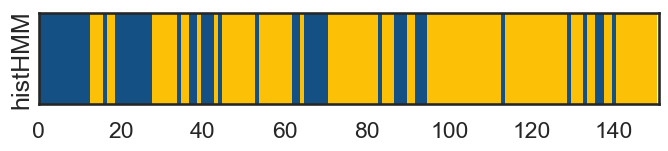

In [351]:
# predicted_states = 1 - predicted_states
# plt.figure(figsize=(8, 4))
# plt.subplot(311)
# plt.imshow(predicted_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# # plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
# # plt.ylim(0, 0.5)
# plt.xlim(0, time_bins)
# plt.ylabel("HMMLearn")
# plt.yticks([])

# hmm_z = 1 - hmm_z
# plt.figure(figsize=(8, 4))
# plt.subplot(312)
# plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# # plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
# # plt.ylim(0, 0.5)
# plt.xlim(0, time_bins)
# plt.ylabel("GaussianHMM")
# plt.yticks([])

# hist_plot = np.array([-1 if state == 0 else state for state in hist_predicted_states])
print(type(hist_plot))
print(type(hist_predicted_states))

plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(hist_predicted_states[None,:], aspect="auto", cmap=cmap)
# plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
# plt.ylim(0, 0.5)
plt.xlim(0, time_bins)

plt.ylabel("histHMM")
plt.yticks([])

plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_predicted_states.pdf', format='pdf')

<BarContainer object of 151 artists>

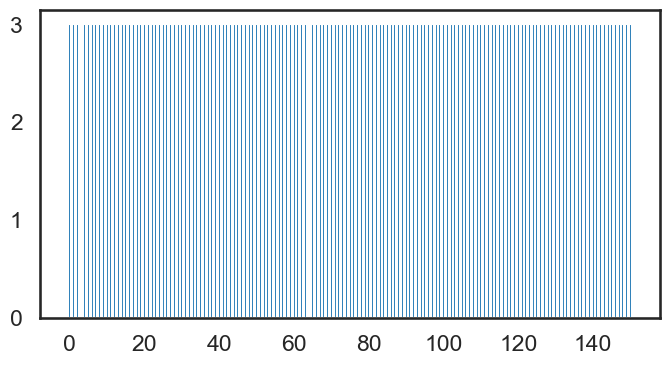

In [352]:
plt.figure(figsize=(8, 4))
plt.bar(range(hist_predicted_states.size), 3)

12
[12, 21, 24, 40, 53, 66, 80, 94, 108, 121, 136, 151]
[0, 12, 21, 24, 40, 53, 66, 80, 94, 108, 121, 136, 151]
[(0, 12), (12, 21), (21, 24), (24, 40), (40, 53), (53, 66), (66, 80), (80, 94), (94, 108), (108, 121), (121, 136), (136, 151)]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1
 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1]
[0.0, 0.5555555555555556, 0.0, 0.5625, 0.6923076923076923, 0.6923076923076923, 0.6428571428571429, 0.5714285714285714, 0.9285714285714286, 0.9230769230769231, 0.8666666666666667, 0.8]


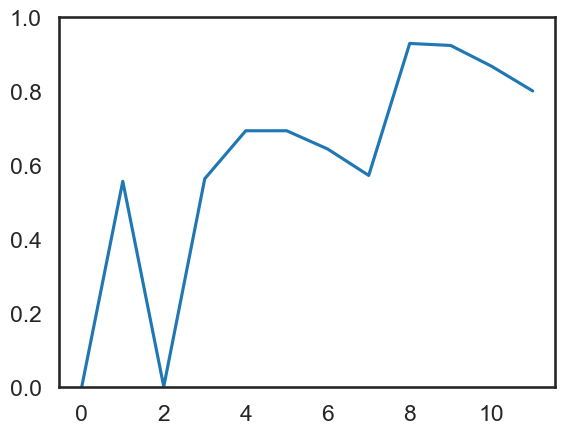

In [353]:
print(len(block_bounds))
print(block_bounds)

new_bounds = [0] + block_bounds
new_bounds = list(np.unique(np.array(new_bounds)))
print(list(np.unique(np.array(new_bounds))))
indices = [(new_bounds[i], new_bounds[i+1]) for i in range(len(new_bounds) - 1)]
print(indices)

print(hist_predicted_states)
percent_mb = [np.mean(hist_predicted_states[start:end]) for start, end in indices]
print(percent_mb)
plt.figure()
plt.ylim([0, 1])
plt.plot(percent_mb)

plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_mb_percentage.eps', format='eps')

In [342]:
def visualize_sigmoids(sigmoid_params, idxs):
    params_list = sigmoid_params[idxs.flatten(), ...]
    plot_sigmoids(epsilon_sigmoid, params_list)
    
def visualize_regimes(state_preds, sigmoid_params):
    plt.figure()
    plt.subplot(211)
    idxs_0 = np.argwhere(state_preds == 0)
    visualize_sigmoids(sigmoid_params, idxs_0)
    plt.figure()
    plt.subplot(212)
    idxs_1 = np.argwhere(state_preds == 1)
    visualize_sigmoids(sigmoid_params, idxs_1)

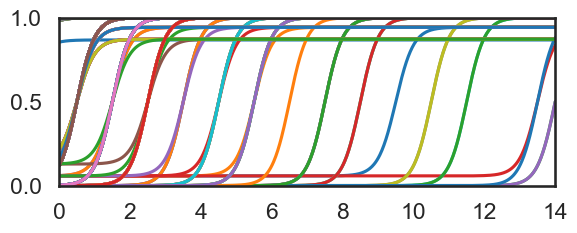

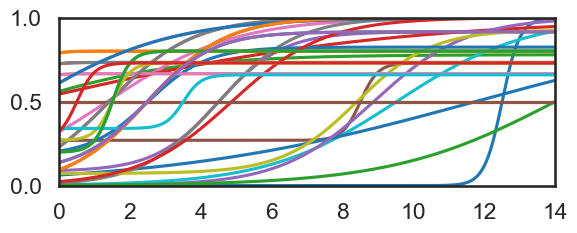

In [237]:
visualize_regimes(predicted_states, np.squeeze(X))

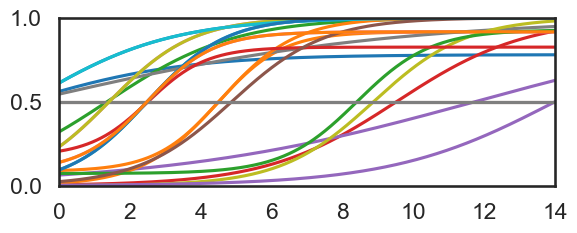

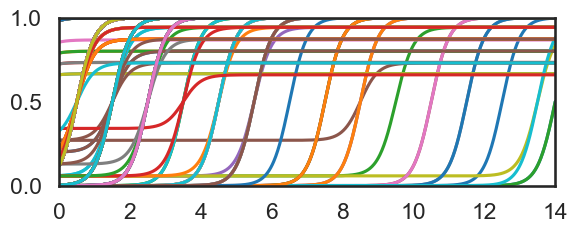

In [238]:
visualize_regimes(hmm_z, np.squeeze(X))

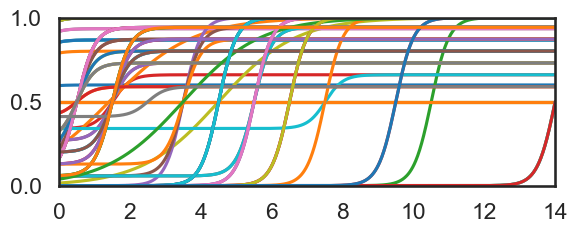

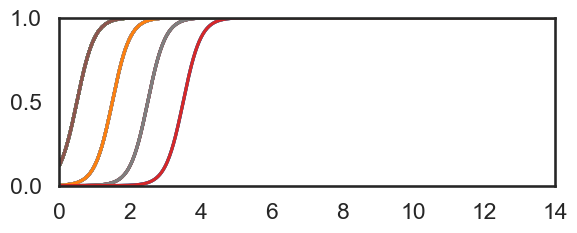

[[0.60850804 0.39149196]
 [0.47878503 0.52121497]]
0.4782608695652174


In [224]:
visualize_regimes(hist_predicted_states, np.squeeze(X))
print(hist_model.transmat_)
print(np.sum(hist_predicted_states)/hist_predicted_states.size)

[[0.5 0.5]
 [0.5 0.5]]
[[0.60850804 0.39149196]
 [0.47878503 0.52121497]]


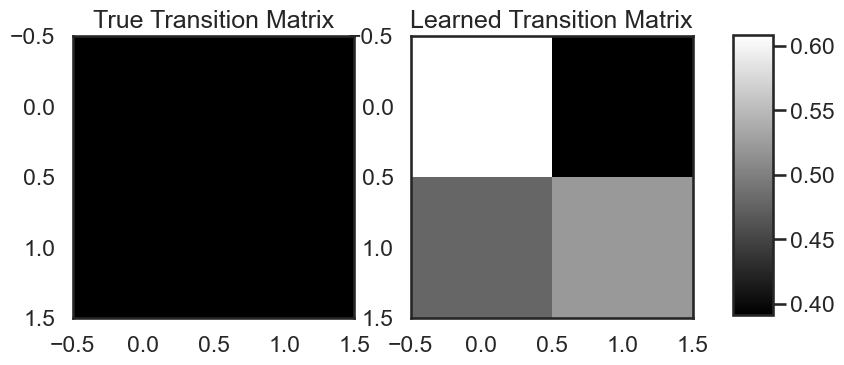

In [225]:
true_transition_mat = transmat
learned_transition_mat = hist_model.transmat_
print(true_transition_mat)
print(learned_transition_mat)

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()